In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Technical analysis
import talib as ta

# Datetime manipulation
from datetime import timedelta

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('_classic_test_patch')

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Helper functions
from option_backtesting_file import get_premium, get_expected_profit_empirical, setup_call_spread, setup_put_spread

In [ ]:
# Read data
options_data = pd.read_pickle('nifty_options_data_2019_2022.bz2')
data = pd.read_pickle('nifty_data_2019_2022.bz2')
data.head()

,spot_open,spot_high,spot_low,spot_close,Expiry,futures_close
Date,,,,,,
2019-01-01,10881.70,10923.60,10807.10,10910.10,2019-01-31,10960.55
2019-01-02,10868.85,10895.35,10735.05,10792.50,2019-01-31,10830.85
2019-01-03,10796.80,10814.05,10661.25,10672.25,2019-01-31,10718.50
2019-01-04,10699.70,10741.05,10628.65,10727.35,2019-01-31,10777.60
2019-01-07,10804.85,10835.95,10750.15,10771.80,2019-01-31,10803.45


In [ ]:
config = {
    
    'stop_loss_percentage': 60,
    'take_profit_percentage': 60, 
    'days_to_exit_before_expiry': 5
}

In [ ]:
# Calculate ADX
data['ADX'] = ta.ADX(data.spot_high, data.spot_low, data.spot_close, timeperiod=14)

# Calculate 20-day SMA
data['sma_20'] = data.spot_close.rolling(20).mean()

# Calculate 50-day SMA
data['sma_50'] = data.spot_close.rolling(50).mean()

# Calculate days to expiry
data['days_to_expiry'] = (data['Expiry'] - data.index).dt.days

In [ ]:
# SMA entry condition
condition_1 = (data['sma_20'] >= data['sma_50'])

# ADX entry condition
condition_2 = (data['ADX'] >= 20)

# SMA entry condition
condition_3 = (data['sma_20'] < data['sma_50'])

# Generate entry signals
data['signal'] = np.where(condition_1 & condition_2, 1, np.nan)
data['signal'] = np.where(condition_3 & condition_2, -1, data['signal'])

In [ ]:
# Generate signal as 0 when days to expiry is less than days to exit before expiry
data['signal'] = np.where(data.days_to_expiry <= config['days_to_exit_before_expiry'], 0, data['signal'])
data.tail()

,spot_open,spot_high,spot_low,spot_close,Expiry,futures_close,ADX,sma_20,sma_50,days_to_expiry,signal
Date,,,,,,,,,,,
2022-05-20,16043.80,16283.05,16003.85,16266.15,2022-05-26,16253.25,25.945619,16513.4950,16949.414,6,-1.0
2022-05-23,16290.95,16414.70,16185.75,16214.70,2022-05-26,16183.35,24.958370,16465.6325,16953.439,3,0.0
2022-05-24,16225.55,16262.80,16078.60,16125.15,2022-05-26,16104.70,24.320691,16424.1925,16949.035,2,0.0
2022-05-25,16196.35,16223.35,16006.95,16025.80,2022-05-26,16013.80,23.914622,16365.4425,16937.653,1,0.0
2022-05-26,16105.00,16204.45,15903.70,16170.15,2022-05-26,16159.05,23.804497,16322.0300,16928.447,0,0.0


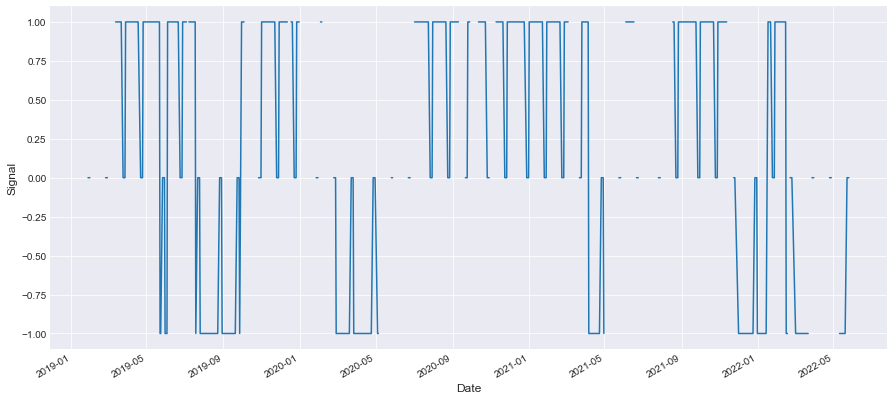

In [ ]:
# Plot cumulative PnL
plt.figure(figsize=(15, 7))
data['signal'].plot()

# Set labels for the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("Signal", fontsize=12)
plt.show()

In [ ]:
def setup_call_spread(futures_price, options_data, direction='bull'):
    
    # Create a dataframe
    call_spread = pd.DataFrame(columns=['Option Type', 'Strike Price', 'position', 'premium'])

    # Calculate ATM strike price
    atm_strike_price = 50 * (round(futures_price / 50))

    # Setup first leg of the spread
    call_spread.loc['0'] = ['CE', atm_strike_price, 1, np.nan]
    
    # Append respective premium for the leg
    call_spread['premium'] = call_spread.apply(lambda r: get_premium(r, options_data), axis=1)
    
    # Define price deviation for next leg of spread
    deviation = round(call_spread.premium.sum() / 50) * 50

    # Setup next leg of the spread
    call_spread.loc['1'] = ['CE', atm_strike_price + deviation, -1, np.nan]
    
    # The above setup is for bull call spread. For setting up bear call spread just multiply the position column by -1
    if direction == 'bear':
        call_spread['position'] *= -1

    # Append respective premiums for the legs
    call_spread['premium'] = call_spread.apply(lambda r: get_premium(r, options_data), axis=1)

    return call_spread


def setup_put_spread(futures_price, options_data, direction='bear'):
    
    # Create a dataframe
    put_spread = pd.DataFrame(columns=['Option Type', 'Strike Price', 'position', 'premium'])

    # Calculate ATM strike price
    atm_strike_price = 50 * (round(futures_price / 50))

    # Setup first leg of the spread
    put_spread.loc['0'] = ['PE', atm_strike_price, 1, np.nan]

    # Append respective premium for the leg
    put_spread['premium'] = put_spread.apply(lambda r: get_premium(r, options_data), axis=1)
    
    # Define price deviation for next leg of spread
    deviation = round(put_spread.premium.sum() / 50) * 50
    
    # Setup next leg of the spread
    put_spread.loc['1'] = ['PE', atm_strike_price - deviation, -1, np.nan]

    # The above setup is for bear put spread. For setting up bull put spread just multiply the position column by -1
    if direction == 'bull':
        put_spread['position'] *= -1

    # Append respective premiums for the legs
    put_spread['premium'] = put_spread.apply(lambda r: get_premium(r, options_data), axis=1)

    return put_spread

In [ ]:
# Step-1: Create dataframes for round trips, storing trades, and mtm
round_trips_details = pd.DataFrame()
trades = pd.DataFrame()
mark_to_market = pd.DataFrame()

# Step-2: Function for calculating mtm
def add_to_mtm(mark_to_market, option_strategy, trading_date):
    option_strategy['Date'] = trading_date
    mark_to_market = pd.concat([mark_to_market, option_strategy])
    return mark_to_market

# Step-3: Initialise current position, number of trades and cumulative pnl to 0
current_position = 0
trade_num = 0
cum_pnl = 0

# Set exit flag to False
exit_flag = False

# Step-4: Set start date for backtesting
start_date = data.index[0] + timedelta(days=90)

In [ ]:
for i in data.loc[start_date:].index:

    if (current_position == 0) & (data.loc[i, 'signal'] != 0):
        
        # Step-5: Setup spread
        options_data_daily = options_data.loc[i]
        
        # If signal is 1 we will setup bull call spread
        if data.loc[i, 'signal'] == 1:        
            spread = setup_call_spread(data.loc[i,'futures_close'], options_data_daily, 'bull') 
            
        # If signal is -1 we will setup bear put spread
        elif data.loc[i, 'signal'] == -1:
            spread = setup_put_spread(data.loc[i,'futures_close'], options_data_daily, 'bear') 
            
        else:
            continue
                
        # List of all strike prices         
        price_range = list(options_data_daily['Strike Price'].unique())        
        
        # start_date for fetching historical data
        start_date = i - timedelta(days=90)        
        
        # Step-6: Calculate Expected profit
        data.loc[i,'exp_profit'] = get_expected_profit_empirical(data.loc[start_date:i], 
                                    spread.copy(), data.loc[i, 'days_to_expiry'], price_range)
        
        # We are going with the historical data 
        if data.loc[i,'exp_profit'] > 0:
            
            # Check that the last price of any of the leg of the spread should be greater than 0
            if (spread.premium.isna().sum() > 0) or ((spread.premium == 0).sum() > 0):
                print(f"\x1b[31mStrike price not liquid so we will ignore this trading opportunity {i}\x1b[0m")
                continue
            
            # Populate the trades dataframe
            trades = spread.copy()
            trades['entry_date'] = i
            trades.rename(columns={'premium':'entry_price'}, inplace=True)            

            # Calculate net premium 
            net_premium = round((spread.position * spread.premium).sum(),1)
            
            # Compute SL and TP for the trade
            premium_sign = np.sign(net_premium)
            sl = net_premium * (1 - config['stop_loss_percentage']*premium_sign/100)
            tp = net_premium * (1 + config['take_profit_percentage']*premium_sign/100)
            
            # Update current position
            current_position = data.loc[i, 'signal']

            # Update mark_to_market dataframe
            mark_to_market = add_to_mtm(mark_to_market, spread, i)
            
            # Increase number of trades by 1
            trade_num += 1   
            print("-"*30)
            
            # Print trade details
            print(f"Trade No: {trade_num} | Entry | Date: {i} | Premium: {net_premium*-1} | Position: {current_position}")            

    # Step-7 :        
    elif current_position != 0:

        # Update net premium
        options_data_daily = options_data.loc[i]
        spread['premium'] = spread.apply(lambda r: get_premium(r, options_data_daily), axis=1)
        net_premium = (spread.position * spread.premium).sum()
        
        # Update mark_to_market dataframe
        mark_to_market = add_to_mtm(mark_to_market, spread, i)
     
        # Exit the trade if any of the exit condition is met
        if data.loc[i, 'signal'] != current_position:
            exit_type = 'Expiry or Signal Based'
            exit_flag = True
            
                    
        elif net_premium < sl:
            exit_type = 'SL'
            exit_flag = True
                   
                    
        elif net_premium > tp:                               
            exit_type = 'TP'
            exit_flag = True
            
            
        if exit_flag:
            
            # Check that the data is present for all strike prices on the exit date
            if spread.premium.isna().sum() > 0:
                print(f"Data missing for the required strike prices on {i}, Not adding to trade logs.")
                current_position = 0
                continue
            
            # Append the trades dataframe
            trades['exit_date'] = i
            trades['exit_type'] = exit_type
            trades['exit_price'] = spread.premium
            
            # Add the trade logs to round trip details
            round_trips_details = pd.concat([round_trips_details,trades])
            
            # Calculate net premium at exit
            net_premium = round((spread.position * spread.premium).sum(),1)   
            
            # Calculate net premium on entry
            entry_net_premium = (trades.position * trades.entry_price).sum() 
            
            # Step-8: Calculate pnl for the trade
            trade_pnl = round(net_premium - entry_net_premium,1)
            
            # Calculate cumulative pnl
            cum_pnl += trade_pnl
            cum_pnl = round(cum_pnl,1)
            
            # Print trade details
            print(f"Trade No: {trade_num} | Exit Type: {exit_type} | Date: {i} | Premium: {net_premium} | PnL: {trade_pnl} | Cum PnL: {cum_pnl}")                              

            # Update current position to 0
            current_position = 0    
            
            # Set exit flag to false
            exit_flag = False          

------------------------------
Trade No: 1 | Entry | Date: 2019-04-01 00:00:00 | Premium: -70.8 | Position: 1.0
Trade No: 1 | Exit Type: Expiry or Signal Based | Date: 2019-04-22 00:00:00 | Premium: 11.5 | PnL: -59.3 | Cum PnL: -59.3
------------------------------
Trade No: 2 | Entry | Date: 2019-04-26 00:00:00 | Premium: -147.4 | Position: 1.0
Trade No: 2 | Exit Type: SL | Date: 2019-05-13 00:00:00 | Premium: 45.8 | PnL: -101.6 | Cum PnL: -160.9
------------------------------
Trade No: 3 | Entry | Date: 2019-05-14 00:00:00 | Premium: -142.6 | Position: 1.0
Trade No: 3 | Exit Type: TP | Date: 2019-05-20 00:00:00 | Premium: 266.2 | PnL: 123.6 | Cum PnL: -37.3
------------------------------
Trade No: 4 | Entry | Date: 2019-05-21 00:00:00 | Premium: -134.7 | Position: 1.0
Trade No: 4 | Exit Type: Expiry or Signal Based | Date: 2019-05-23 00:00:00 | Premium: 91.5 | PnL: -43.2 | Cum PnL: -80.5
------------------------------
Trade No: 5 | Entry | Date: 2019-06-04 00:00:00 | Premium: -72.9 | 

In [ ]:
# Round trip details
round_trips_details.head()

,Option Type,Strike Price,position,entry_price,entry_date,exit_date,exit_type,exit_price
0,CE,11750,1,164.00,2019-04-01,2019-04-22,Expiry or Signal Based,14.8
1,CE,11900,-1,93.15,2019-04-01,2019-04-22,Expiry or Signal Based,3.3
0,CE,11800,1,302.45,2019-04-26,2019-05-13,SL,77.6
1,CE,12100,-1,155.05,2019-04-26,2019-05-13,SL,31.8
0,CE,11250,1,308.00,2019-05-14,2019-05-20,TP,699.0


In [ ]:
# MTM details
mark_to_market.head()

,Option Type,Strike Price,position,premium,Date
0,CE,11750,1,164.00,2019-04-01
1,CE,11900,-1,93.15,2019-04-01
0,CE,11750,1,185.90,2019-04-02
1,CE,11900,-1,108.35,2019-04-02
0,CE,11750,1,149.00,2019-04-03


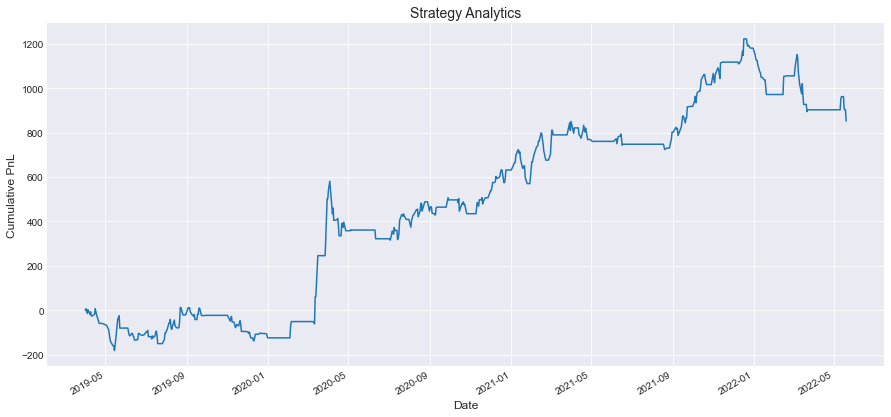

In [ ]:
mark_to_market['net_premium'] = mark_to_market.position * mark_to_market.premium

# Strategy analytics
analytics = pd.DataFrame()
analytics['change_in_pnl'] = mark_to_market.groupby('Date').net_premium.sum().diff()
analytics.loc[analytics.index.isin(round_trips_details.entry_date),'change_in_pnl'] = 0

# Calculate cumulative PnL
analytics['cum_pnl'] = analytics['change_in_pnl'].cumsum()

# Plot cumulative PnL
plt.figure(figsize=(15, 7))
analytics['cum_pnl'].plot()

# Set labels for the plot
plt.title("Strategy Analytics", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative PnL", fontsize=12)
plt.show()